# 25. Carbon isotope stack construction
Here we construct a global carbon isotopes using a number of records located around the world including 
* 3 North Altantic sites (IODP U1308, IODP 552, IODP U1313 / ODP 607),
* 3 Equatorial Atlantic sites (ODP 659, ODP 664, and ODP 925),
* 1 site from the South Atlantic (ODP 1088),
* 1 site from the SW Indian (IODP U1474),
* 3 Indo-Pacific Sites (ODP 1143, ODP 758, and IODP 1489),
* 3 Southern Ocean sites (IODP U1475, ODP 1090, and TTN057),
* two Pacific sites (ODP 849, and ODP 846).

These records are normalized and standardized then averaged together to create a stack. This notebook produces supplementary figure 12 and supplementary table 7.

## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline

### Set paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'

### Import data
#### Orbital

In [3]:
orb=pd.read_csv(misc_path+'/milankovitch.data.csv')
orb['pindex']=np.sin(orb['perihelion'])*orb['eccentricity']
orb['Age (kyr)']=orb['age']*1000
orb=orb.loc[0:5300]
orb=orb.set_index('Age (kyr)')

In [4]:
insol30s=pd.read_csv(misc_path+'insolation30N.txt',sep='\s',
                  header=None,engine='python',names=['Age (kyr)','insolation']).astype(float)
insol30s=insol30s.set_index('Age (kyr)')
insol30s['insolation']=(insol30s['insolation']-insol30s['insolation'].mean())*-1+insol30s['insolation'].mean()

In [5]:
pad_width=20
lpfilt=signal.butter(1,[1/(400+pad_width),1/(400-pad_width)],btype='band',analog=False,output='sos')
filtered=signal.sosfiltfilt(lpfilt,insol30s['insolation'])
insol30s['400kyr']=filtered

### Import carbon isotope records
#### Global compilation

In [6]:
comp=pd.read_csv(misc_path+'full_compilation_benthic.csv',index_col='Age [ka BP]')

#### North Atlantic

##### IODP U1313 / ODP 607

In [7]:
benths1313=pd.read_csv(misc_path+'s607ageSBP90isoadj.txt',sep='\t')
benths1313=benths1313.dropna().set_index('age SBP90 (kyr)')
d13c1313=benths1313['607 C13'].copy()

In [8]:
benths607=pd.read_csv(misc_path+'607_cib_stable_isotopes.csv',index_col='ageSBP90')
d13c607=benths607['C13'].loc[0:2000].copy()

##### IODP U1308

In [9]:
d13cU1308=comp['U1308_d13C']

##### ODP 552

In [10]:
d13c552=comp['DSDP552_d13C']

#### Equatorial Atlantic

##### ODP 659

In [11]:
benths659=pd.read_csv(misc_path+'108-659_isotopes.tab',sep='\t',header=21,index_col='Age [ka BP]')
benths659=benths659.sort_index()
d13c659=benths659['C. wuellerstorfi δ13C [‰ PDB]'].loc[0:2000].copy()

##### ODP 664

In [12]:
d13c664=comp['ODP664_d13C'].dropna()

##### ODP 925

In [13]:
benths925=pd.read_csv(misc_path+'154-925_d13C.csv',index_col='Age (ka)')
d13c925=benths925['d13C']

#### South Atlantic / Southwest Indian

##### ODP 1088

In [14]:
d13c1088=comp['ODP1088_d13C'].dropna()

In [15]:
benthsU1474=pd.read_csv(table_path+'Supplementary Table 1 - Benthic foram chemistry.csv')

##### IODP U1474

In [16]:
amU1474=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
amU1474['Top Interval Depth CCSF (m)']=amU1474['Depth CCSF (m)'].shift(1)
amU1474['Top Interval Age (kyr)']=amU1474['Age (kyr)'].shift(1)
famU1474=interpolate.interp1d(amU1474['Depth CCSF (m)'],amU1474['Age (kyr)'],bounds_error=False)

In [17]:
benthsU1474['Depositional Age (kyr)']=famU1474(benthsU1474['Top depth CCSF (m)'])
abenthsU1474=benthsU1474.set_index('Depositional Age (kyr)',drop=False)

In [18]:
d13cU1474=abenthsU1474['benthic d13C'].loc[0:1200].copy()

#### Indo-Pacific

##### ODP 1143

In [19]:
d13c1143=comp['ODP1143_d13C'].copy()

##### ODP 758

In [20]:
am758=pd.read_csv(misc_path+'758_LR04age.txt',header=None,sep='\s',engine='python',
                  names=['Depth comp [mcd]','1','Age model [ka]','2','d18O'])
am758=am758.dropna(axis=1).groupby(by='Depth comp [mcd]').mean()
am758.loc[0,'Age model [ka]']=0
am758=am758.sort_index()
fam758=interpolate.interp1d(am758.index,am758['Age model [ka]'],bounds_error=False,fill_value='extrapolate')

In [21]:
benths758=pd.read_csv(misc_path+'121-758-benthics.csv')
mbenths758=benths758.groupby(by='Composite Depth, m').mean(numeric_only=True)
mbenths758['Age model [ka]']=fam758(mbenths758.index)
mbenths758=mbenths758.iloc[:-1]
d13c758=mbenths758.set_index('Age model [ka]')['d13C']

##### IODP U1489

In [22]:
benthsU1489=pd.read_csv(misc_path+'U1489_benthics.csv')

In [23]:
amU1489=pd.read_csv(misc_path+'U1489_agemodel.csv')
famU1489=interpolate.interp1d(amU1489['CCSF (m)'],amU1489['Age (ka)'],bounds_error=False)

In [24]:
benthsU1489['Depositional Age (kyr)']=famU1489(benthsU1489['Sample Depth CCSF m'])

In [25]:
benthsU1489['d13c_pereg_adjusted']=benthsU1489['U. peregrina δ13C (PDB‰)']+.9
benthsU1489['d13c_mund_adjusted']=benthsU1489['C. mundulus δ13C (PDB‰)']-.08
benthsU1489['d13c_wull_adjusted']=benthsU1489['C. wuellerstorfi δ13C (PDB‰)']-.08
benthsU1489['d13c_rob_adjusted']=benthsU1489['C. robertsonianus δ13C (PDB‰)']-.08
benthsU1489['d13c_eq']=benthsU1489[['d13c_pereg_adjusted','d13c_mund_adjusted',
                                    'd13c_wull_adjusted','d13c_rob_adjusted']].mean(axis=1)

In [26]:
d13cU1489=benthsU1489.set_index('Depositional Age (kyr)',drop=False)['d13c_eq'].copy()

#### Southern Ocean

##### IODP U1475

In [27]:
benthsU1475=pd.read_csv(misc_path+'Starr_isotopes.tab',sep='\t',header=33,
                        index_col='Age [ka BP] (median)')
d13cU1475=benthsU1475['C. wuellerstorfi δ13C [‰ PDB]']

##### TTN057

In [28]:
TTN057=pd.read_csv(misc_path+'TTN057-6_d18O_d13C.tab',sep='\t',header=23,
                   index_col='Age [ka BP]')

##### ODP 1090

In [29]:
d13c1090=pd.concat([TTN057['C. wuellerstorfi δ13C [‰ PDB]'].dropna(),
                    comp['ODP1090_d13C'].dropna()])

#### Pacific Ocean

In [30]:
d13c849=comp['ODP849_d13C'].dropna()
d13c846=comp['ODP846_d13C'].dropna()

## Create Stacks
### North Atlantic Deep Water

In [31]:
nadw=pd.DataFrame(index=np.linspace(0,2000,2001))

In [32]:
nadw_sites=['607','1308','925','659','664','1088','U1474']
nadw_data=[d13c607,d13cU1308,d13c925,d13c659,d13c664,d13c1088,d13cU1474]

In [33]:
nadws_raw={}
nadws_noU={}
nadws_means=[]
nadws_std={}
for i,site in enumerate(nadw_sites):
    nadws_raw[site]=nadw_data[i].loc[0:2000].copy()
    mean=nadws_raw[site].mean()
    nadws_means.append(mean)
    nadws_noU[site]=nadws_raw[site]-mean
    nadws_std[site]=nadws_noU[site]/nadws_raw[site].std()

In [34]:
for i,site in enumerate(nadw_sites):
    fraw=interpolate.interp1d(nadws_raw[site].index,
                              nadws_raw[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fnoU=interpolate.interp1d(nadws_noU[site].index,
                              nadws_noU[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fstd=interpolate.interp1d(nadws_std[site].index,
                              nadws_std[site].values,
                              bounds_error=False,fill_value='extrapolate')
    minage=nadws_raw[site].index[0]
    maxage=nadws_raw[site].index[-1]
    nadw.loc[nadw.loc[minage:maxage].index,site+' raw']=fraw(nadw.loc[minage:maxage].index)
    nadw_mean=sum(nadws_means)/len(nadws_means)
    nadw.loc[nadw.loc[minage:maxage].index,site+' noU']=fnoU(nadw.loc[minage:maxage].index)+nadw_mean
    nadw.loc[nadw.loc[minage:maxage].index,site+' std']=fstd(nadw.loc[minage:maxage].index)
    if (site==['607'])|(site==['659'])|(site==['U1474']):
        nadw[site+' raw']=nadw[site+' raw'].rolling(5,center=True).mean()
        nadw[site+' noU']=nadw[site+' noU'].rolling(5,center=True).mean()        
        nadw[site+' std']=nadw[site+' std'].rolling(5,center=True).mean()        

In [75]:
nadw

,607 raw,607 noU,607 std,1308 raw,1308 noU,1308 std,925 raw,925 noU,925 std,659 raw,...,U1474 std,raw stack,noU stack,std stack,raw 1s,noU 1s,std 1s,raw filt,noU filt,std filt
0.0,1.050000,0.774964,0.839718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.050000,0.774964,0.839718,NaN,NaN,NaN,0.481796,0.417453,0.093275
1.0,0.858969,0.583933,0.430593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.858969,0.583933,0.430593,NaN,NaN,NaN,0.481794,0.417451,0.093271
2.0,1.141250,0.866214,1.035146,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,...,NaN,0.985625,0.826642,1.077966,0.220087,0.055964,0.060556,0.481792,0.417450,0.093267
3.0,1.142759,0.867723,1.038377,NaN,NaN,NaN,NaN,NaN,NaN,0.993158,...,NaN,1.067958,0.908975,1.305792,0.105784,0.058339,0.378183,0.481790,0.417449,0.093264
4.0,0.970345,0.695309,0.669123,0.932462,0.943588,1.513626,NaN,NaN,NaN,1.134444,...,NaN,0.883938,0.830114,1.216220,0.271500,0.228772,0.631792,0.481789,0.417447,0.093260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996.0,0.785294,0.510258,0.272806,NaN,NaN,NaN,0.727301,0.506856,0.35731,-0.000390,...,NaN,0.504069,0.324598,-0.183898,0.437835,0.318631,0.865250,0.481723,0.417434,0.093285
1997.0,0.682353,0.407317,0.052340,NaN,NaN,NaN,0.767374,0.546929,0.47280,NaN,...,NaN,0.724863,0.477123,0.262570,0.060119,0.098720,0.297311,0.481723,0.417434,0.093286
1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
nadw['raw stack']=nadw.iloc[:,::3].mean(axis=1)
nadw['noU stack']=nadw.iloc[:,1::3].mean(axis=1)
nadw['std stack']=nadw.iloc[:,2::3].mean(axis=1)

In [36]:
nadw['raw 1s']=nadw.iloc[:,:-3:3].std(axis=1)
nadw['noU 1s']=nadw.iloc[:,1:-3:3].std(axis=1)
nadw['std 1s']=nadw.iloc[:,2:-3:3].std(axis=1)

### Circumpolar Deep Water

In [37]:
cdw=pd.DataFrame(index=np.linspace(0,2000,2001))

In [38]:
cdw_sites=['1090','U1475','758','1143','U1489','846','849']
cdw_data=[d13c1090,d13cU1475,d13c758,d13c1143,d13cU1489,d13c846,d13c849]
# cdw_sites=['758','1143','U1489','846','849']
# cdw_data=[d13c758,d13c1143,d13cU1489,d13c846,d13c849]

In [39]:
cdws_raw={}
cdws_noU={}
cdws_means=[]
cdws_std={}
for i,site in enumerate(cdw_sites):
    cdws_raw[site]=cdw_data[i].loc[0:2000].copy()
    mean=cdws_raw[site].mean()
    cdws_means.append(mean)
    cdws_noU[site]=cdws_raw[site]-mean
    cdws_std[site]=cdws_noU[site]/cdws_raw[site].std()

In [40]:
for i,site in enumerate(cdw_sites):
    fraw=interpolate.interp1d(cdws_raw[site].index,
                              cdws_raw[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fnoU=interpolate.interp1d(cdws_noU[site].index,
                              cdws_noU[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fstd=interpolate.interp1d(cdws_std[site].index,
                              cdws_std[site].values,
                              bounds_error=False,fill_value='extrapolate')
    minage=cdws_raw[site].index[0]
    maxage=cdws_raw[site].index[-1]
    cdw.loc[cdw.loc[:maxage].index,site+' raw']=fraw(cdw.loc[:maxage].index)
    cdw_mean=sum(cdws_means)/len(cdws_means)
    cdw.loc[cdw.loc[:maxage].index,site+' noU']=fnoU(cdw.loc[:maxage].index)+cdw_mean
    cdw.loc[cdw.loc[:maxage].index,site+' std']=fstd(cdw.loc[:maxage].index)

In [41]:
cdw['raw stack']=cdw.iloc[:,::3].mean(axis=1)
cdw['noU stack']=cdw.iloc[:,1::3].mean(axis=1)
cdw['std stack']=cdw.iloc[:,2::3].mean(axis=1)

In [42]:
cdw['raw 1s']=cdw.iloc[:,:-3:3].std(axis=1)
cdw['noU 1s']=cdw.iloc[:,1:-3:3].std(axis=1)
cdw['std 1s']=cdw.iloc[:,2:-3:3].std(axis=1)

## All

In [43]:
globl=pd.DataFrame(index=np.linspace(0,2000,2001))

In [44]:
globl_sites=nadw_sites+cdw_sites
globl_data=nadw_data+cdw_data

In [45]:
globls_raw={}
globls_noU={}
globls_means=[]
globls_std={}
for i,site in enumerate(globl_sites):
    globls_raw[site]=globl_data[i].loc[0:2000].copy()
    mean=globls_raw[site].mean()
    globls_means.append(mean)
    globls_noU[site]=globls_raw[site]-mean
    globls_std[site]=globls_noU[site]/globls_raw[site].std()

In [46]:
for i,site in enumerate(globl_sites):
    fraw=interpolate.interp1d(globls_raw[site].index,
                              globls_raw[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fnoU=interpolate.interp1d(globls_noU[site].index,
                              globls_noU[site].values,
                              bounds_error=False,fill_value='extrapolate')
    fstd=interpolate.interp1d(globls_std[site].index,
                              globls_std[site].values,
                              bounds_error=False,fill_value='extrapolate')
    minage=globls_raw[site].index[0]
    maxage=globls_raw[site].index[-1]
    globl.loc[globl.loc[:maxage].index,site+' raw']=fraw(globl.loc[:maxage].index)
    globl_mean=sum(globls_means)/len(globls_means)
    globl.loc[globl.loc[:maxage].index,site+' noU']=fnoU(globl.loc[:maxage].index)+globl_mean
    globl.loc[globl.loc[:maxage].index,site+' std']=fstd(globl.loc[:maxage].index)
    globl[site+' raw']=globl[site+' raw'].rolling(5,center=True).mean()
    globl[site+' noU']=globl[site+' noU'].rolling(5,center=True).mean()        
    globl[site+' std']=globl[site+' std'].rolling(5,center=True).mean()   

In [60]:
global_sites_raw=[name+' raw' for name in globl_sites]
global_sites_noU=[name+' noU' for name in globl_sites]
global_sites_std=[name+' std' for name in globl_sites]

In [61]:
globl['raw stack']=globl[global_sites_raw].mean(axis=1)
globl['noU stack']=globl[global_sites_noU].mean(axis=1)
globl['std stack']=globl[global_sites_std].mean(axis=1)

In [62]:
globl['raw 1s']=globl[global_sites_raw].std(axis=1)
globl['noU 1s']=globl[global_sites_noU].std(axis=1)
globl['std 1s']=globl[global_sites_std].std(axis=1)

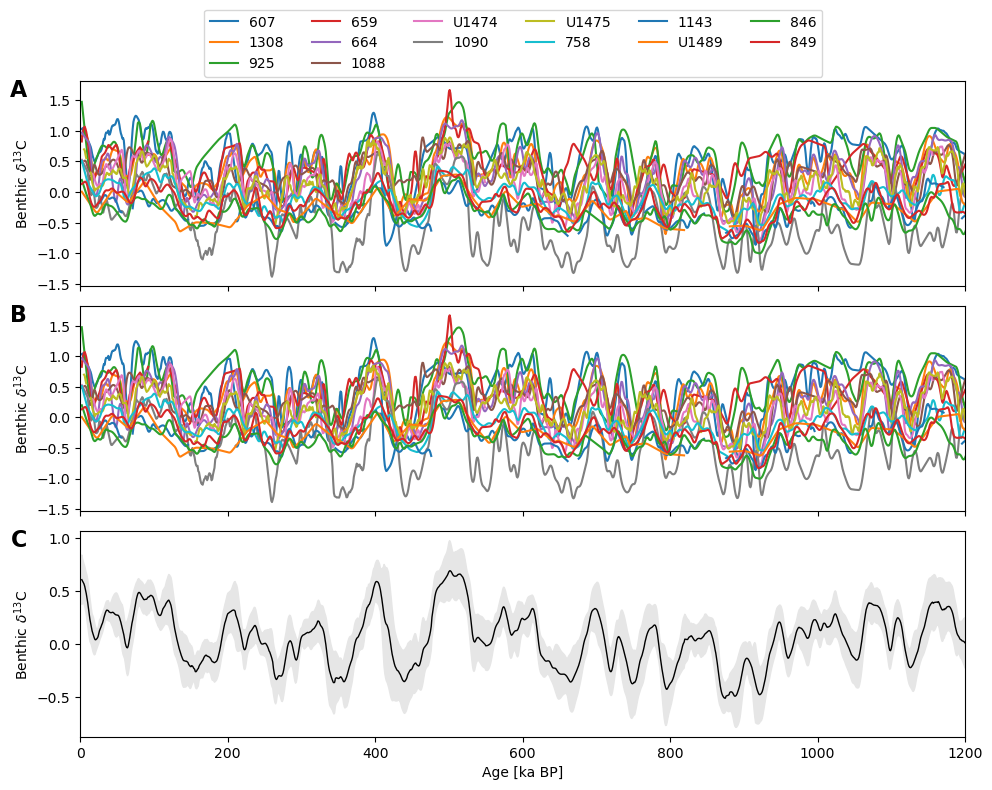

In [93]:
fig,axes=plt.subplots(nrows=3,figsize=(10,8),sharex=True,facecolor='w')
ax=axes[0]
globl[global_sites_names].plot(ax=ax,label=globl_sites)
ax.legend(globl_sites,ncol=6,fontsize=10,loc=(.14,1.02))
ax.set_ylabel('Benthic $\delta^{13}$C')

ax=axes[1]
globl[global_sites_names].plot(ax=ax,label=globl_sites,legend=False)
ax.set_ylabel('Benthic $\delta^{13}$C')

ax=axes[2]
stack_kind=globl
stack_method='noU'

benthxs=stack_kind[stack_method+' stack'].index
benthys=stack_kind[stack_method+' stack']
benth_plus_s=stack_kind[stack_method+' stack']+stack_kind[stack_method+' 1s']
benth_minus_s=stack_kind[stack_method+' stack']-stack_kind[stack_method+' 1s']
ax.fill_between(x=benthxs,y1=benth_minus_s,y2=benth_plus_s,color='#e6e6e6')
ax.plot(benthxs,benthys,lw=1,color='k')
ax.set_ylabel('Benthic $\delta^{13}$C')
ax.set_xlabel('Age [ka BP]')

axes[-1].set_xlim(0,1200)
plt.tight_layout()

letters=['A','B','C']
for i,ax in enumerate(axes):
    ax.annotate(letters[i],xy=(-.06,.9),ha='right',va='bottom',fontweight='bold',xycoords='axes fraction',
                fontsize=16)

fig.savefig(sup_figure_path+'Extended Data Figure 12 - Constructing a global stack of carbon isotopes.png',dpi=300)

### Lowpass filt

In [94]:
pad_width=20
lpfilt=signal.butter(1,1/(400),btype='low',analog=False,output='sos')
bpfilt=signal.butter(1,[1/(400+1.5),1/(400-1.5)],btype='band',analog=False,output='sos')

In [95]:
def normalize(inp):
    mean=np.mean(inp)
    de_mean=inp-mean
    std=np.std(inp)
    standardized=de_mean/std
    return standardized

In [96]:
def pad(inp):
    len_ts=len(inp)
    padded=np.zeros(3*len_ts)
    padded[len_ts*1:len_ts*2]=inp
    return len_ts,padded

In [97]:
def filt(inp):
    mean=np.mean(inp)
    std=np.std(inp)
    len_ts,padded=pad(normalize(inp))
    long_result=signal.sosfiltfilt(bpfilt,padded)
    result=long_result[len_ts*1:len_ts*2]*std+mean
    return result

In [98]:
for col in ['raw','noU','std']:
#     filteredcdw=signal.sosfiltfilt(lpfilt,cdw[col+' stack'].dropna())
    filteredcdw=filt(cdw[col+' stack'].dropna())
    cdw[col+' filt']=np.nan
    cdw.loc[cdw[col+' stack'].dropna().index,col+' filt']=filteredcdw

#     filterednadw=signal.sosfiltfilt(lpfilt,nadw[col+' stack'].dropna())
    filterednadw=filt(nadw[col+' stack'].dropna())
    nadw[col+' filt']=np.nan
    nadw.loc[nadw[col+' stack'].dropna().index,col+' filt']=filterednadw
    
#     filteredglobl=signal.sosfiltfilt(lpfilt,globl[col+' stack'].dropna())
    filteredglobl=filt(globl[col+' stack'].dropna())
    globl[col+' filt']=np.nan
    globl.loc[globl[col+' stack'].dropna().index,col+' filt']=filteredglobl

In [99]:
col_list=['607 raw','1308 raw','925 raw','659 raw','664 raw', '1088 raw','U1474 raw','1090 raw', 
          'U1475 raw','758 raw','1143 raw','U1489 raw','846 raw','849 raw','noU stack','noU 1s','noU filt']

In [100]:
stack_export=globl[col_list].reset_index()

In [101]:
sites=[i.split(' ', 1)[0] for i in col_list[:-3]]
stack_names=['stack','1s','filt']
new_names=['Age [ka BP]']+sites+stack_names

In [102]:
stack_export.columns=new_names

In [103]:
stack_export

,Age [ka BP],607,1308,925,659,664,1088,U1474,1090,U1475,758,1143,U1489,846,849,stack,1s,filt
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.032665,0.913385,1.472673,0.825626,0.9705,0.4845,0.526752,0.510435,NaN,0.511480,NaN,0.004419,0.197,0.13150,0.604530,0.232414,0.113708
3,3.0,1.016240,0.922923,1.358181,0.940667,0.9535,0.4915,0.502147,0.488696,NaN,0.465698,NaN,-0.013163,0.159,0.14050,0.591609,0.212069,0.113706
4,4.0,1.049279,0.932462,1.243689,1.015298,0.9365,0.4985,0.477542,0.466957,NaN,0.419314,NaN,-0.030744,0.121,0.14950,0.579393,0.198543,0.113705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185000,NaN,NaN,NaN,NaN,NaN,-0.34625,0.298584,0.517211,0.113798
1997,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,1998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
stack_export.to_csv(table_path+'Supplementary Table 7 - Global benthic d13C stack.csv',index=False)